To generate synthetic VisiumHD data from Xenium, please read and run all the cells below. Thanks!

## Download Xenium output from 10X website
Paste the URL for the binned_outputs.tar.gz for the sample you want to analyze.

1. Go to Xenium public datasets page:https://www.10xgenomics.com/datasets?query=&page=1&configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000&refinementList%5Bproduct.name%5D%5B0%5D=In%20Situ%20Gene%20Expression&refinementList%5Bspecies%5D%5B0%5D=Human&refinementList%5BdiseaseStates%5D%5B0%5D=colorectal%20cancer

2. Select sample to analyze scrolling down to downloads section, click "Batch download"


### Install prerequisite libraries

In [1]:
import zipfile

# 指定 ZIP 文件的路径
zip_file_path = "/home/wangzhuo/data/Xenium_Human_Colorectal_Cancer/Xenium_V1_Human_Colorectal_Cancer_Addon_FFPE_outs.zip"

# 解压 ZIP 文件到指定目录
extract_dir = "/home/wangzhuo/data/Xenium_Human_Colorectal_Cancer"  # 可以修改为你想要的解压目录

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extraction completed. Files are extracted to: {extract_dir}")

Extraction completed. Files are extracted to: /home/wangzhuo/data/Xenium_Human_Colorectal_Cancer


### Import Relevant Libraries

In [1]:
import geopandas as gpd # Geopandas for storing Shapely objects
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata
import os
import gzip
import numpy as np
import re
import shapely
from shapely.geometry import Polygon, Point # Representing bins and cells as Shapely Polygons and Point objects
from shapely import wkt

### Load Cell & Transcripts Info

In [2]:
# Load the transcript data
transcripts_path = "/home/wangzhuo/data/Xenium_Human_Colorectal_Cancer/transcripts.csv.gz"
with gzip.open(transcripts_path, 'rt') as f:
    transcripts_df = pd.read_csv(f)

# Load cell info
cells_path = "/home/wangzhuo/data/Xenium_Human_Colorectal_Cancer/cells.csv.gz"
with gzip.open(cells_path, 'rt') as f:
    cells_df = pd.read_csv(f)


### Load Cell Boundary Info

In [3]:
import zarr

zarr_file = zarr.open('/home/wangzhuo/data/Xenium_Human_Colorectal_Cancer/cells.zarr.zip', mode='r')
print(zarr_file.tree())

/
 ├── cell_id (388175, 2) uint32
 ├── cell_summary (388175, 8) float64
 ├── masks
 │   ├── 0 (20493, 51115) uint32
 │   ├── 1 (20493, 51115) uint32
 │   └── homogeneous_transform (4, 4) float32
 └── polygon_sets
     ├── 0
     │   ├── cell_index (388175,) uint32
     │   ├── method (388175,) uint32
     │   ├── num_vertices (388175,) int32
     │   └── vertices (388175, 50) float32
     └── 1
         ├── cell_index (388175,) uint32
         ├── method (388175,) uint32
         ├── num_vertices (388175,) int32
         └── vertices (388175, 50) float32


细胞核顶点数据	人 zarr_file['polygon_sets/0/vertices'][:]	小鼠 zarr_file['polygon_vertices'][0, :, :]

整个细胞顶点数据	人 zarr_file['polygon_sets/1/vertices'][:] 小鼠	zarr_file['polygon_vertices'][1, :, :]

In [4]:
file = zarr_file['polygon_sets/0/vertices'][:]
# 1 is whole cell, 0 is nucleus

### Create folders to store synthetic data

For both the `seqfish_dir` and `enact_data_dir`, change `"/home/oneai/"` to the directory that stores this repo.

In [5]:
xenium_dir = "/home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks" # Update it to the directory where you want to save the synthetic data
enact_data_dir = "/home/wangzhuo/data/enact_synthetic_output_HumanCRC/chunks" # Directory that saves all the input and results of the enact pipeline, 
# should end with "oneai-dda-spatialtr-visiumhd_analysis/cache/seqfish/chunks"

transcripts_df_chunks_dir = os.path.join(xenium_dir, "transcripts_patches") # Directory to store the files that contain the transcripts info for each chunk
output_dir = os.path.join(enact_data_dir, "bins_gdf") # Directory to store the results of gene-to-bin assignment for each chunk
cells_df_chunks_dir =  os.path.join(enact_data_dir,"cells_gdf") 
ground_truth_dir =  os.path.join(xenium_dir, "ground_truth_nuclei")

# Making relevant directories
os.makedirs(xenium_dir, exist_ok=True)
os.makedirs(enact_data_dir, exist_ok=True)
os.makedirs(transcripts_df_chunks_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(cells_df_chunks_dir, exist_ok=True)
os.makedirs(ground_truth_dir, exist_ok=True)

### Generate Synthetic VisiumHD Dataset

#### Break transcripts df to patches (based on location)

Break transcripts df to patches of size 1000um x 1000um (larger patch size may result in memory issue)

In [6]:
# patch size: 1000 um x 1000 um

patch_size = 1000

# patch indices
transcripts_df['x_patch'] = (transcripts_df['x_location'] // patch_size).astype(int)
transcripts_df['y_patch'] = (transcripts_df['y_location'] // patch_size).astype(int)
transcripts_df["patch_id"] = transcripts_df["x_patch"].astype(str) + "_" + transcripts_df["y_patch"].astype(str)

# Create a df for each patch
grouped = transcripts_df.groupby(['x_patch', 'y_patch'])
for (x_patch, y_patch), group in grouped:
    # Calculate the start and end locations for each patch
    # x_start = x_patch * patch_size
    # x_end = (x_patch + 1) * patch_size
    # y_start = y_patch * patch_size
    # y_end = (y_patch + 1) * patch_size
    
    filename = f"patch_{x_patch}_{y_patch}.csv"
    output_loc = os.path.join(transcripts_df_chunks_dir , filename)
    group.to_csv(output_loc)

    print(f"Saved {filename}")

Saved patch_0_0.csv
Saved patch_0_1.csv
Saved patch_0_2.csv
Saved patch_0_3.csv
Saved patch_1_0.csv
Saved patch_1_1.csv
Saved patch_1_2.csv
Saved patch_1_3.csv
Saved patch_2_0.csv
Saved patch_2_1.csv
Saved patch_2_2.csv
Saved patch_2_3.csv
Saved patch_3_0.csv
Saved patch_3_1.csv
Saved patch_3_2.csv
Saved patch_3_3.csv
Saved patch_4_0.csv
Saved patch_4_1.csv
Saved patch_4_2.csv
Saved patch_4_3.csv
Saved patch_4_4.csv
Saved patch_5_0.csv
Saved patch_5_1.csv
Saved patch_5_2.csv
Saved patch_5_3.csv
Saved patch_5_4.csv
Saved patch_6_0.csv
Saved patch_6_1.csv
Saved patch_6_2.csv
Saved patch_6_3.csv
Saved patch_6_4.csv
Saved patch_7_0.csv
Saved patch_7_1.csv
Saved patch_7_2.csv
Saved patch_7_3.csv
Saved patch_7_4.csv
Saved patch_8_0.csv
Saved patch_8_1.csv
Saved patch_8_2.csv
Saved patch_8_3.csv
Saved patch_8_4.csv
Saved patch_9_0.csv
Saved patch_9_1.csv
Saved patch_9_2.csv
Saved patch_9_3.csv
Saved patch_9_4.csv
Saved patch_10_1.csv
Saved patch_10_2.csv
Saved patch_10_3.csv
Saved patch_10_4.

#### Generate synthetic visiumHD for each patch

Each patch is broken into bins of size 2um x 2um. The synthetic data contains transcript counts orgnized by bin_id. Each row contains transcript counts for a unique bin. Bins with no transcript counts is not included. 

In addition to all the gene features, there are two additional columns represent the row number and column number of the bin, and a column contains the Shapely polygon item that represents the bin. The first column is the bin_id.

In [7]:
def generate_synthetic_VisiumHD_data(transcripts_df, bin_size=2, whole_cell=True, QScore20=True):
    filtered_df = transcripts_df.copy()
    # only count transcripts in the nucleus
    if not whole_cell:
        filtered_df = transcripts_df[transcripts_df['overlaps_nucleus'] == 1].copy()
    
    #only count transcripts with QScore >= 20
    if QScore20:
        filtered_df = filtered_df[filtered_df['qv'] >= 20].copy()
 
    # assigne bin to each transcript
    filtered_df.loc[:, 'row'] =np.ceil(filtered_df['y_location'] / bin_size).astype(int)
    filtered_df.loc[:, 'column'] = np.ceil(filtered_df['x_location'] / bin_size).astype(int)
    filtered_df.loc[:, 'assigned_bin_id'] = filtered_df.apply(
        lambda row: f"{bin_size}um_" + str(row['row']).zfill(5) +"_"+ str(row['column']).zfill(5),
        axis=1)
    
    bin_coordinates = filtered_df[['assigned_bin_id', 'row', 'column']].drop_duplicates().set_index('assigned_bin_id')
    bin_gene_matrix = filtered_df.groupby(['assigned_bin_id', 'feature_name']).size().unstack(fill_value=0)
    bin_gene_matrix_with_coords = bin_gene_matrix.merge(bin_coordinates, left_index=True, right_index=True)
    
    return bin_gene_matrix_with_coords

In [8]:
# Extract row and column number from the bin_id
def extract_numbers(entry):
    match = re.search(r'_(\d{5})_(\d{5})', entry)
    if match:
        number1 = int(match.group(1).lstrip('0'))  
        number2 = int(match.group(2).lstrip('0'))  
        return number2*2-1, number1*2-1
    else:
        return None, None

In [9]:
from tqdm import tqdm
def generate_bin_polys(bins_df, x_col, y_col, bin_size):
        """Represents the bins as Shapely polygons

        Args:
            bins_df (pd.DataFrame): bins dataframe
            x_col (str): column with the bin centre x-coordinate
            y_col (str): column with the bin centre y-coordinate
            bin_size (int): bin size in pixels

        Returns:
            list: list of Shapely polygons
        """
        geometry = []
        # Generates Shapely polygons to represent each bin

        if True:
            half_bin_size = bin_size / 2
            bbox_coords = pd.DataFrame(
                {
                    "min_x": bins_df[x_col] - half_bin_size,
                    "min_y": bins_df[y_col] - half_bin_size,
                    "max_x": bins_df[x_col] + half_bin_size,
                    "max_y": bins_df[y_col] + half_bin_size,
                }
            )
            geometry = [
                shapely.geometry.box(min_x, min_y, max_x, max_y)
                for min_x, min_y, max_x, max_y in tqdm(
                    zip(
                        bbox_coords["min_x"],
                        bbox_coords["min_y"],
                        bbox_coords["max_x"],
                        bbox_coords["max_y"],
                    ),
                    total=len(bins_df),
                )
            ]

        return geometry

下面这段代码的主要任务是：

处理多个转录本数据文件（chunks）。

对每个转录本数据文件进行筛选和分配到bin中。



调整bin的行列坐标。
将bin转换为Shapely多边形对象。

创建包含地理空间信息的GeoDataFrame。

将处理后的数据保存为CSV文件，并输出成功信息。
这段代码适用于需要对大量单细胞空间转录组数据进行批量处理和空间分析的场景。

In [10]:
# Loop through all the transcripra_df chunks and generate gene-to-bin assignments 
patch_size = 1000
bin_size = 2
transcripts_df_chunks = os.listdir(transcripts_df_chunks_dir)
for chunk_fname in transcripts_df_chunks:
    output_loc = os.path.join(output_dir, chunk_fname)
    # if os.path.exists(output_loc):
    #     continue
    if chunk_fname in [".ipynb_checkpoints"]:
        continue
    transcripts_df_chunk = pd.read_csv(os.path.join(transcripts_df_chunks_dir, chunk_fname))
    bin_df_chunk = generate_synthetic_VisiumHD_data(transcripts_df_chunk, bin_size, whole_cell=True, QScore20=True)
    bin_df_chunk['column'] = bin_df_chunk['column']*2-1
    bin_df_chunk['row'] = bin_df_chunk['row']*2-1
    bin_df_chunk['geometry'] = generate_bin_polys(bin_df_chunk, 'column', 'row', 2)
    bin_gdf_chunk = gpd.GeoDataFrame( bin_df_chunk, geometry = bin_df_chunk['geometry'])
    bin_df_chunk.to_csv(output_loc)
    print(f"Successfully assigned transcripts to bins for {chunk_fname}")

100%|██████████| 29564/29564 [00:00<00:00, 107128.89it/s]


Successfully assigned transcripts to bins for patch_0_0.csv


100%|██████████| 116474/116474 [00:00<00:00, 136925.63it/s]


Successfully assigned transcripts to bins for patch_0_1.csv


100%|██████████| 114212/114212 [00:00<00:00, 137360.55it/s]


Successfully assigned transcripts to bins for patch_0_2.csv


100%|██████████| 48869/48869 [00:00<00:00, 143224.50it/s]


Successfully assigned transcripts to bins for patch_0_3.csv


100%|██████████| 86057/86057 [00:00<00:00, 128541.06it/s]


Successfully assigned transcripts to bins for patch_1_0.csv


100%|██████████| 207381/207381 [00:01<00:00, 138193.42it/s]


Successfully assigned transcripts to bins for patch_1_1.csv


100%|██████████| 163887/163887 [00:01<00:00, 134369.37it/s]


Successfully assigned transcripts to bins for patch_1_2.csv


100%|██████████| 74159/74159 [00:00<00:00, 126343.22it/s]


Successfully assigned transcripts to bins for patch_1_3.csv


100%|██████████| 164052/164052 [00:01<00:00, 135461.89it/s]


Successfully assigned transcripts to bins for patch_2_0.csv


100%|██████████| 185760/185760 [00:01<00:00, 139231.63it/s]


Successfully assigned transcripts to bins for patch_2_1.csv


100%|██████████| 174597/174597 [00:01<00:00, 135066.28it/s]


Successfully assigned transcripts to bins for patch_2_2.csv


100%|██████████| 99432/99432 [00:00<00:00, 148799.96it/s]


Successfully assigned transcripts to bins for patch_2_3.csv


100%|██████████| 150496/150496 [00:01<00:00, 136159.81it/s]


Successfully assigned transcripts to bins for patch_3_0.csv


100%|██████████| 190170/190170 [00:01<00:00, 127321.65it/s]


Successfully assigned transcripts to bins for patch_3_1.csv


100%|██████████| 212488/212488 [00:01<00:00, 140513.76it/s]


Successfully assigned transcripts to bins for patch_3_2.csv


100%|██████████| 129728/129728 [00:01<00:00, 128664.28it/s]


Successfully assigned transcripts to bins for patch_3_3.csv


100%|██████████| 168501/168501 [00:01<00:00, 132147.80it/s]


Successfully assigned transcripts to bins for patch_4_0.csv


100%|██████████| 208910/208910 [00:01<00:00, 132260.38it/s]


Successfully assigned transcripts to bins for patch_4_1.csv


100%|██████████| 173329/173329 [00:01<00:00, 139431.14it/s]


Successfully assigned transcripts to bins for patch_4_2.csv


100%|██████████| 80077/80077 [00:00<00:00, 144463.08it/s]


Successfully assigned transcripts to bins for patch_4_3.csv


100%|██████████| 4984/4984 [00:00<00:00, 52179.37it/s]


Successfully assigned transcripts to bins for patch_4_4.csv


100%|██████████| 177991/177991 [00:01<00:00, 137021.28it/s]


Successfully assigned transcripts to bins for patch_5_0.csv


100%|██████████| 171183/171183 [00:01<00:00, 136709.17it/s]


Successfully assigned transcripts to bins for patch_5_1.csv


100%|██████████| 182367/182367 [00:01<00:00, 136811.98it/s]


Successfully assigned transcripts to bins for patch_5_2.csv


100%|██████████| 122488/122488 [00:00<00:00, 134328.80it/s]


Successfully assigned transcripts to bins for patch_5_3.csv


100%|██████████| 51598/51598 [00:00<00:00, 123946.53it/s]


Successfully assigned transcripts to bins for patch_5_4.csv


100%|██████████| 164754/164754 [00:01<00:00, 136336.88it/s]


Successfully assigned transcripts to bins for patch_6_0.csv


100%|██████████| 171924/171924 [00:01<00:00, 138035.20it/s]


Successfully assigned transcripts to bins for patch_6_1.csv


100%|██████████| 174107/174107 [00:01<00:00, 135437.19it/s]


Successfully assigned transcripts to bins for patch_6_2.csv


100%|██████████| 194064/194064 [00:01<00:00, 138743.61it/s]


Successfully assigned transcripts to bins for patch_6_3.csv


100%|██████████| 61402/61402 [00:00<00:00, 143445.21it/s]


Successfully assigned transcripts to bins for patch_6_4.csv


100%|██████████| 185415/185415 [00:01<00:00, 132273.28it/s]


Successfully assigned transcripts to bins for patch_7_0.csv


100%|██████████| 228841/228841 [00:01<00:00, 140097.26it/s]


Successfully assigned transcripts to bins for patch_7_1.csv


100%|██████████| 186837/186837 [00:01<00:00, 137691.03it/s]


Successfully assigned transcripts to bins for patch_7_2.csv


100%|██████████| 182744/182744 [00:01<00:00, 134447.20it/s]


Successfully assigned transcripts to bins for patch_7_3.csv


100%|██████████| 64029/64029 [00:00<00:00, 134539.55it/s]


Successfully assigned transcripts to bins for patch_7_4.csv


100%|██████████| 49661/49661 [00:00<00:00, 144334.22it/s]


Successfully assigned transcripts to bins for patch_8_0.csv


100%|██████████| 193570/193570 [00:01<00:00, 134452.01it/s]


Successfully assigned transcripts to bins for patch_8_1.csv


100%|██████████| 200388/200388 [00:01<00:00, 140622.74it/s]


Successfully assigned transcripts to bins for patch_8_2.csv


100%|██████████| 175617/175617 [00:01<00:00, 134625.95it/s]


Successfully assigned transcripts to bins for patch_8_3.csv


100%|██████████| 16818/16818 [00:00<00:00, 123013.80it/s]


Successfully assigned transcripts to bins for patch_8_4.csv


100%|██████████| 2312/2312 [00:00<00:00, 145479.56it/s]

Successfully assigned transcripts to bins for patch_9_0.csv



100%|██████████| 67036/67036 [00:00<00:00, 122575.14it/s]


Successfully assigned transcripts to bins for patch_9_1.csv


100%|██████████| 191105/191105 [00:01<00:00, 130719.84it/s]


Successfully assigned transcripts to bins for patch_9_2.csv


100%|██████████| 225490/225490 [00:01<00:00, 132567.98it/s]


Successfully assigned transcripts to bins for patch_9_3.csv


100%|██████████| 12710/12710 [00:00<00:00, 141738.64it/s]


Successfully assigned transcripts to bins for patch_9_4.csv


100%|██████████| 8766/8766 [00:00<00:00, 140220.16it/s]


Successfully assigned transcripts to bins for patch_10_1.csv


100%|██████████| 80502/80502 [00:00<00:00, 139419.08it/s]


Successfully assigned transcripts to bins for patch_10_2.csv


100%|██████████| 121132/121132 [00:00<00:00, 134346.70it/s]


Successfully assigned transcripts to bins for patch_10_3.csv


100%|██████████| 2829/2829 [00:00<00:00, 140695.39it/s]

Successfully assigned transcripts to bins for patch_10_4.csv


### Generate cell_gdf as enact_pipeline input

This session generate the cell_df patches required to run the enact pipeline. The main purpose is to create Shapely polygons that represent the cell outline.

为什么要转换为Shapely多边形对象


几何操作: Shapely多边形对象提供了丰富的几何操作功能，如计算面积、周长、交集、并集、包含关系等。这些功能在空间转录组数据分析中非常有用，例如计算多边形之间的重叠区域，或者判断一个细胞是否位于某个多边形内。
空间分析: 使用多边形对象可以更容易地进行空间分析和可视化。在单细胞空间转录组数据分析中，理解细胞在组织切片中的空间分布是非常重要的。

与其他库的兼容性: Shapely多边形对象与其他空间分析相关的库（如GeoPandas）兼容良好。通过将多边形对象添加到GeoDataFrame中，可以方便地进行进一步的空间分析和处理。

总结来说，这段代码通过将坐标数组转换为Shapely多边形对象，并将其添加到DataFrame中，为后续的空间分析和可视化提供了几何基础。

In [11]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

# Assuming cells_df is already loaded and contains 'polygons' column
# Create polygons if not already done
def create_polygons(coords_array):
    polygons = []
    for row in coords_array:
        reshaped_coords = row.reshape(-1, 2)
        polygon = Polygon(reshaped_coords)
        polygons.append(polygon)
    return polygons

polygons = create_polygons(file)
cells_df['polygons'] = polygons

# Convert to GeoDataFrame
cell_gdf = gpd.GeoDataFrame(cells_df, geometry=cells_df['polygons'])
cell_gdf.rename(columns={'x_centroid': 'cell_x', 'y_centroid': 'cell_y'}, inplace=True)

# Define patch size (same as transcripts)
patch_size = 1000

# Assign patch indices to cells based on their centroids
cell_gdf['x_patch'] = (cell_gdf['cell_x'] // patch_size).astype(int)
cell_gdf['y_patch'] = (cell_gdf['cell_y'] // patch_size).astype(int)
cell_gdf['patch_id'] = cell_gdf['x_patch'].astype(str) + "_" + cell_gdf['y_patch'].astype(str)

# Group by patch_id and save each group as a separate file
grouped = cell_gdf.groupby(['x_patch', 'y_patch'])
for (x_patch, y_patch), group in grouped:
    filename = f"patch_{x_patch}_{y_patch}.csv"
    output_loc = os.path.join(cells_df_chunks_dir, filename)
    
    # Save only the required columns
    group[['cell_id', 'cell_x', 'cell_y', 'geometry']].to_csv(output_loc, index=False)
    print(f"Saved {filename}")

Saved patch_0_0.csv
Saved patch_0_1.csv
Saved patch_0_2.csv
Saved patch_0_3.csv
Saved patch_1_0.csv
Saved patch_1_1.csv
Saved patch_1_2.csv
Saved patch_1_3.csv
Saved patch_2_0.csv
Saved patch_2_1.csv
Saved patch_2_2.csv
Saved patch_2_3.csv
Saved patch_3_0.csv
Saved patch_3_1.csv
Saved patch_3_2.csv
Saved patch_3_3.csv
Saved patch_4_0.csv
Saved patch_4_1.csv
Saved patch_4_2.csv
Saved patch_4_3.csv
Saved patch_4_4.csv
Saved patch_5_0.csv
Saved patch_5_1.csv
Saved patch_5_2.csv
Saved patch_5_3.csv
Saved patch_5_4.csv
Saved patch_6_0.csv
Saved patch_6_1.csv
Saved patch_6_2.csv
Saved patch_6_3.csv
Saved patch_6_4.csv
Saved patch_7_0.csv
Saved patch_7_1.csv
Saved patch_7_2.csv
Saved patch_7_3.csv
Saved patch_7_4.csv
Saved patch_8_0.csv
Saved patch_8_1.csv
Saved patch_8_2.csv
Saved patch_8_3.csv
Saved patch_8_4.csv
Saved patch_9_0.csv
Saved patch_9_1.csv
Saved patch_9_2.csv
Saved patch_9_3.csv
Saved patch_9_4.csv
Saved patch_10_1.csv
Saved patch_10_2.csv
Saved patch_10_3.csv
Saved patch_10_4.

### Run ENACT bin-to-cell pipeline
In the configs.yaml file: 

    Set "analysis_name" in the configs.yaml file to "xenium" (or "xenium_nuclei).
    Set "run_synthetic" to True and all other steps to False.
    Set "bin_to_cell_method" to one of these four: "naive", "weighted_by_area", "weighted_by_gene", or "weighted_by_cluster"

Run `make run_enact`

In [15]:
from enact.pipeline import ENACT
import os

In [ ]:
from enact.pipeline import ENACT
import yaml

configs_path = "/home/wangzhuo/Experiments/visiumHD/enact-pipeline/config/configs_copy.yaml" # Change this to the location of the configs.yaml file that you just edited
with open(configs_path, "r") as stream:
    configs = yaml.safe_load(stream)

so_hd = ENACT(configs_dict=configs)
so_hd.run_enact()

2025-08-06 10:20:11,426 - ENACT - INFO - <initiate_instance_variables> ENACT running with the following configurations: 
 analysis_name: chunks
 run_synthetic: True
 cache_dir: /home/wangzhuo/data/oneai-dda-spatialtr-visiumhd_analysis/cache/xenium_nuclei
 wsi_path: None
 visiumhd_h5_path: None
 tissue_positions_path: None
 bins_gdf_dir: /home/wangzhuo/data/oneai-dda-spatialtr-visiumhd_analysis/cache/xenium_nuclei/chunks/bins_gdf
 cells_gdf_path: /home/wangzhuo/data/oneai-dda-spatialtr-visiumhd_analysis/cache/xenium_nuclei/chunks/cells_gdf.csv
 segmentation: False
 bin_to_geodataframes: False
 bin_to_cell_assignment: True
 cell_type_annotation: False
 seg_method: stardist
 image_type: he
 nucleus_expansion: True
 expand_by_nbins: 2
 patch_size: 4000
 bin_representation: polygon
 bin_to_cell_method: weighted_by_area
 cell_annotation_method: celltypist
 cell_typist_model: Human_Colorectal_Cancer.pkl
 use_hvg: True
 n_hvg: 1000
 destripe_norm: False
 n_clusters: 4
 n_pcs: 250
 chunks_to_ru

In [12]:
from enact.pipeline import ENACT
so_hd = ENACT(
    run_synthetic=True,
    cache_dir="/home/wangzhuo/data",  # 自定义缓存目录
    wsi_path = False,
    visiumhd_h5_path =  False,
    tissue_positions_path = False,
    analysis_name="enact_synthetic_output_HumanCRC",  # 自定义分析名称
    segmentation=False,
    bin_to_cell_assignment=False,
    bin_to_geodataframes=False,
    cell_type_annotation=False,
    bin_to_cell_method="weighted_by_area",
    cell_typist_model= "Human_Colorectal_Cancer.pkl",
    
    
)

2025-08-20 15:21:44.644361: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 15:21:44.708423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755674504.740820  209426 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755674504.749905  209426 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755674504.804682  209426 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [13]:
so_hd.run_enact()

2025-08-20 15:21:50,118 - ENACT - INFO - <assign_bins_to_cells_synthetic> Assigning bins to cells using weighted_by_area method
100%|██████████| 50/50 [00:00<00:00, 284552.51it/s]


### Generate Ground Truth

The following cell will generate and save the ground truth of the synthetic VisiumHD data for the use of bin-to-cell assignment methods evaluation. Ground truth dataframe consists of rows representing the transcript counts of each cell. Each column represents a gene feature (gene feature name is also the column name).

#### Generate Cell-gene matrix for evaluation

In [14]:
def generate_ground_truth_table(transcripts_df, cells_df, whole_cell=True, QScore20=True, include_unassigned_transcript=False):
    filtered_df = transcripts_df
    
    # only count transcripts in the nucleus
    if not whole_cell:
        filtered_df = transcripts_df[transcripts_df['overlaps_nucleus'] == 1]
    
    # only count transcripts with QScore >= 20
    if QScore20:
        filtered_df = filtered_df[filtered_df['qv'] >= 20]
    
    # only count transcripts that are assigned to specific cells
    if not include_unassigned_transcript:
        filtered_df = filtered_df[filtered_df['cell_id'] != 'UNASSIGNED']
    
    pivot_df = filtered_df.pivot_table(index='cell_id', columns='feature_name', aggfunc='size', fill_value=0)
    
    merged_df = pivot_df.merge(cells_df[['cell_id']], left_index=True, right_on='cell_id', how='right')
    columns = ['cell_id'] + [col for col in merged_df.columns if col not in ['cell_id', 'x_centroid', 'y_centroid','polygons']]
    merged_df = merged_df[columns]
    merged_df.set_index('cell_id', inplace=True)
    #merged_df['total_gene_counts'] = merged_df.iloc[:, 3:].sum(axis=1)
    
    return merged_df

In [15]:
bin_size = 2
cell_df_chunks = os.listdir(cells_df_chunks_dir)
for chunk_fname in cell_df_chunks:
    output_loc = os.path.join(ground_truth_dir,chunk_fname)
    if os.path.exists(output_loc):
        continue
    if chunk_fname in [".ipynb_checkpoints"]:
        continue
    cell_df_chunk = pd.read_csv(os.path.join(cells_df_chunks_dir, chunk_fname))
    groundtruth_chunk = generate_ground_truth_table(transcripts_df, cell_df_chunk, whole_cell=False, QScore20=False, include_unassigned_transcript=False)
    groundtruth_chunk.to_csv(output_loc)
    print(f"Successfully generated groundthuth for {chunk_fname}")

Successfully generated groundthuth for patch_0_0.csv
Successfully generated groundthuth for patch_0_1.csv
Successfully generated groundthuth for patch_0_2.csv
Successfully generated groundthuth for patch_0_3.csv
Successfully generated groundthuth for patch_1_0.csv
Successfully generated groundthuth for patch_1_1.csv
Successfully generated groundthuth for patch_1_2.csv
Successfully generated groundthuth for patch_1_3.csv
Successfully generated groundthuth for patch_2_0.csv
Successfully generated groundthuth for patch_2_1.csv
Successfully generated groundthuth for patch_2_2.csv
Successfully generated groundthuth for patch_2_3.csv
Successfully generated groundthuth for patch_3_0.csv
Successfully generated groundthuth for patch_3_1.csv
Successfully generated groundthuth for patch_3_2.csv
Successfully generated groundthuth for patch_3_3.csv
Successfully generated groundthuth for patch_4_0.csv
Successfully generated groundthuth for patch_4_1.csv
Successfully generated groundthuth for patch_4

In [43]:
ground_truth_dir

'/home/wangzhuo/data/synthetic_data/xenium_HumanCRC/ground_truth_nuclei'

In [16]:
import pandas as pd
import numpy as np

#method = "weighted_by_cluster"
results_dir =  "/home/wangzhuo/data/enact_synthetic_output/chunks/weighted_by_area/bin_to_cell_assign"

# Initialize variables to accumulate weighted precision, recall, and F1
total_cells = 0
precision_sum = 0
recall_sum = 0
missing_cells_count = 0
total_cells_count = 0
results_chunks = os.listdir(results_dir)

for chunk_fname in results_chunks:
    if chunk_fname in [".ipynb_checkpoints"]:
        continue

    generated = pd.read_csv(os.path.join(results_dir, chunk_fname))
    ground_truth = pd.read_csv(os.path.join(ground_truth_dir, chunk_fname))
    if len(generated) ==0:
        print(chunk_fname)
        continue
    generated.rename(columns={'id': 'cell_id'}, inplace=True)
  
    # Align both dataframes by 'cell_id', filling missing cells in generated with 0
    merged = pd.merge(ground_truth, generated, on='cell_id', how='left', suffixes=('_gt', '_gen')).fillna(0)
    num_cells = (ground_truth.iloc[:, 1:] != 0).any(axis=1).sum()
    missing_cells_count += num_cells - len(generated)
    total_cells_count += num_cells

    ground_truth_aligned = merged.filter(like='_gt').values
    generated_aligned = merged.filter(like='_gen').values
    assert ground_truth_aligned.shape == generated_aligned.shape, "Aligned matrices must have the same shape!"

    num_cells = ground_truth_aligned.shape[0]

    # Compute precision for the current patch
    patch_precision = np.sum(np.minimum(generated_aligned, ground_truth_aligned)) / np.sum(generated_aligned)

    # Compute recall for the current patch
    patch_recall = np.sum(np.minimum(generated_aligned, ground_truth_aligned)) / np.sum(ground_truth_aligned)

    # F1 score for the current patch
    if patch_precision + patch_recall > 0:
        patch_f1 = 2 * (patch_precision * patch_recall) / (patch_precision + patch_recall)
    else:
        patch_f1 = 0

    # Accumulate the weighted precision, recall, and number of aligned cells
    precision_sum += patch_precision * num_cells
    recall_sum += patch_recall * num_cells
    total_cells += num_cells
    
#  Compute overall weighted precision, recall, and F1 score
overall_precision = precision_sum / total_cells
overall_recall = recall_sum / total_cells

if overall_precision + overall_recall > 0:
    overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)
else:
    overall_f1_score = 0 

# Print results
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1_score}")
print(f"Total missing cells in the generated data compared to ground truth: {missing_cells_count}")
print(f"Total cells : {total_cells_count}")

Overall Precision: 0.6871310079191713
Overall Recall: 0.7853240553322285
Overall F1 Score: 0.732953450534569
Total missing cells in the generated data compared to ground truth: 337
Total cells : 388175


### Evaluation of ENACT bin-to-cell results

#### Overall precision, recall, and f1

Run this session with all the methods you have run with ENACT, change 'method' in the cell bellow to the one you want to evaluate.

#### Visualize the distribution using violin plots 

The following cells would create violin plots for all four methods in order to better compare the results. You can choose to only compare the ones you have run by changing the 'methods' list below to only include those.

In [49]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define methods and their directories
methods = [
   
    {
        'name': 'Weighted_by_area',
        'results_dir': os.path.join(enact_data_dir,"chunks", "weighted_by_area", "bin_to_cell_assign"),       
        'ground_truth_dir':ground_truth_dir
    }

]

# Initialize a list to store per-patch metrics for all methods
metrics_list = []

# Loop through each method to compute per-patch metrics
for method in methods:
    method_name = method['name']
    results_dir = method['results_dir']
    ground_truth_dir = method['ground_truth_dir']
    
    print(f"Processing {method_name}...")
    
    # Get list of generated and ground truth files
    generated_files = [f for f in os.listdir(results_dir) if f.endswith('.csv') and f not in [".ipynb_checkpoints"]]
    ground_truth_files = [f for f in os.listdir(ground_truth_dir) if f.endswith('.csv') and f not in [".ipynb_checkpoints"]]
    
    # Find common files between generated results and ground truth
    common_files = set(generated_files) & set(ground_truth_files)
    
    if not common_files:
        print(f"No common files found for {method_name}. Skipping method.")
        continue
    
    # Loop through each common file (patch)
    for fname in common_files:
        ground_truth_path = os.path.join(ground_truth_dir, fname)
        generated_path = os.path.join(results_dir, fname)
        
        # Load ground truth and generated data
        ground_truth = pd.read_csv(ground_truth_path)
        generated = pd.read_csv(generated_path)
        
        # Skip if generated data is empty
        if generated.empty:
            print(f"No data in generated file {fname} for {method_name}. Skipping patch.")
            continue
        
        # Rename columns for consistency
        if 'id' in generated.columns:
            generated.rename(columns={'id': 'cell_id'}, inplace=True)
        
        # Merge ground truth and generated data on 'cell_id', filling missing values with 0
        merged = pd.merge(
            ground_truth, generated, on='cell_id', how='outer', suffixes=('_gt', '_gen')
        ).fillna(0)
        
        # Extract aligned matrices for ground truth and generated data
        ground_truth_aligned = merged.filter(regex='_gt$').values
        generated_aligned = merged.filter(regex='_gen$').values
        
        # Ensure matrices are aligned
        if ground_truth_aligned.shape != generated_aligned.shape:
            print(f"Shape mismatch in patch {fname} for {method_name}. Skipping patch.")
            continue
        
        # Compute counts for this patch
        tp = np.sum(np.minimum(generated_aligned, ground_truth_aligned))
        predicted = np.sum(generated_aligned)
        actual = np.sum(ground_truth_aligned)
        
        # Compute metrics for this patch
        precision = tp / predicted if predicted > 0 else 0
        recall = tp / actual if actual > 0 else 0
        f1_score = (
            2 * (precision * recall) / (precision + recall)
            if (precision + recall) > 0 else 0
        )
        
        # Store metrics for this patch
        metrics_list.append({
            'Method': method_name,
            'Patch': fname,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score
        })

# Create a DataFrame with per-patch metrics
metrics_df = pd.DataFrame(metrics_list)

# Display the first few rows of the DataFrame
print("\nPer-Patch Metrics:")
print(metrics_df.head())

Processing Weighted_by_area...

Per-Patch Metrics:
             Method          Patch  Precision    Recall  F1 Score
0  Weighted_by_area  patch_8_3.csv   0.701516  0.787675  0.742103
1  Weighted_by_area  patch_3_0.csv   0.667302  0.801889  0.728431
2  Weighted_by_area  patch_3_1.csv   0.668662  0.789532  0.724087
3  Weighted_by_area  patch_3_3.csv   0.700275  0.816932  0.754118
4  Weighted_by_area  patch_5_1.csv   0.699031  0.743723  0.720685


25805355.py (8): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

25805355.py (16): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

25805355.py (24): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



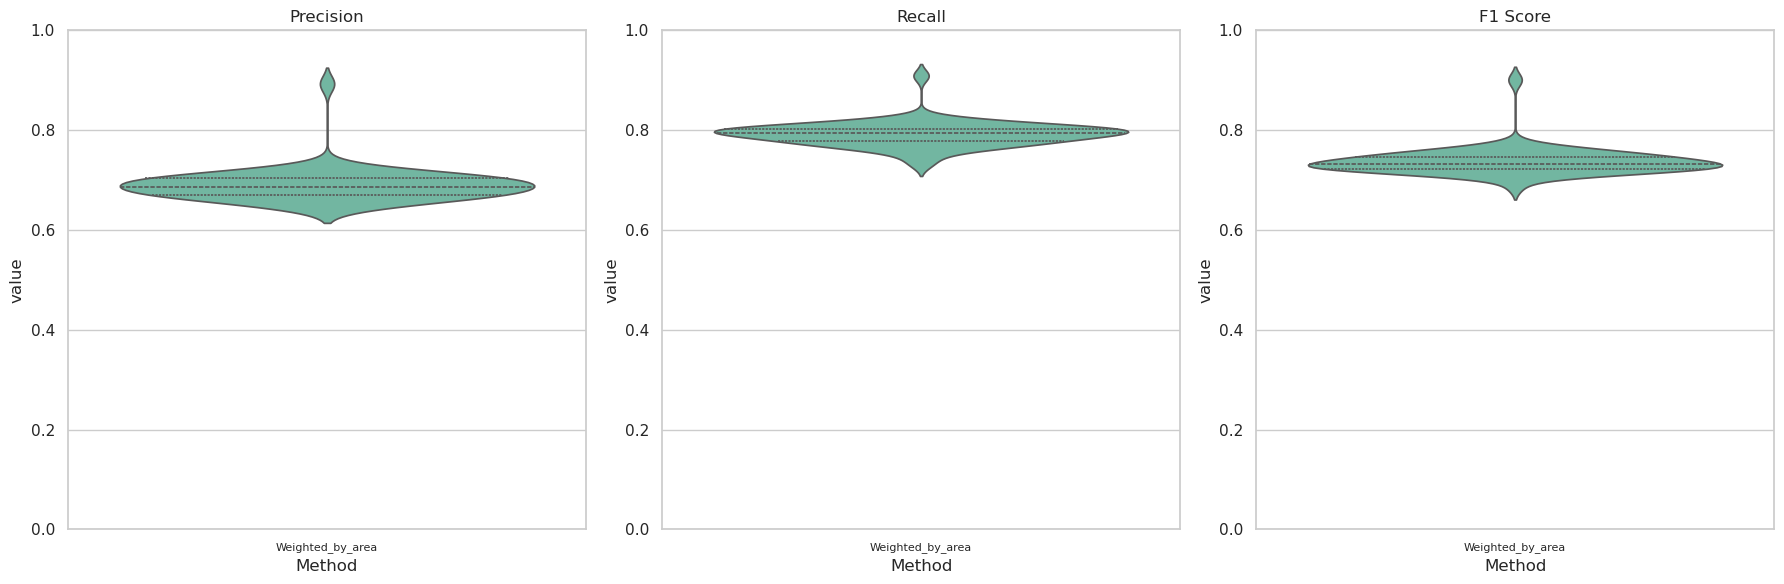

In [50]:
# plotting
sns.set(style="whitegrid")

# Create a figure with subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision Violin Plot
sns.violinplot(x='Method', y='Precision', data=metrics_df, ax=axes[0], inner='quartile', palette='Set2')
axes[0].set_title('Precision')
axes[0].set_xlabel('Method')
axes[0].set_ylabel('value')
axes[0].set_ylim(0,1)
axes[0].tick_params(axis='x', labelsize=8)  # Adjust the font size here

# Recall Violin Plot
sns.violinplot(x='Method', y='Recall', data=metrics_df, ax=axes[1], inner='quartile', palette='Set2')
axes[1].set_title('Recall')
axes[1].set_xlabel('Method')
axes[1].set_ylabel('value')
axes[1].set_ylim(0,1)
axes[1].tick_params(axis='x', labelsize=8)  # Adjust the font size here

# F1 Score Violin Plot
sns.violinplot(x='Method', y='F1 Score', data=metrics_df, ax=axes[2], inner='quartile', palette='Set2')
axes[2].set_title('F1 Score')
axes[2].set_xlabel('Method')
axes[2].set_ylabel('value')
axes[2].set_ylim(0,1)
axes[2].tick_params(axis='x', labelsize=8)  # Adjust the font size here

plt.tight_layout()
plt.show()